In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch

import promonet

/home/mrm5248/micromamba/envs/promonet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


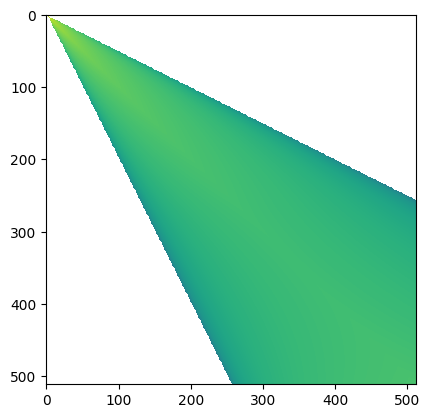

In [55]:
# Transition matrix
frequencies = torch.abs(torch.fft.fftfreq(
    promonet.NUM_FFT,
    1 / promonet.SAMPLE_RATE
)[:promonet.NUM_FFT // 2 + 1])[1:]
logfreq = torch.log2(frequencies)
transition = 1. - torch.cdist(logfreq[None, :, None], logfreq[None, :, None], p=1.0)[0]
transition[transition < 0.] = 0.
transition /= transition.sum(dim=1, keepdims=True)
transition = torch.log(transition)
transition[transition < -60.] = float('nan')
plt.imshow(transition)

In [56]:
frequencies

tensor([   21.5332,    43.0664,    64.5996,    86.1328,   107.6660,   129.1992,
          150.7324,   172.2656,   193.7988,   215.3320,   236.8652,   258.3984,
          279.9316,   301.4648,   322.9980,   344.5312,   366.0645,   387.5977,
          409.1309,   430.6641,   452.1973,   473.7305,   495.2637,   516.7969,
          538.3301,   559.8633,   581.3965,   602.9297,   624.4629,   645.9961,
          667.5293,   689.0625,   710.5957,   732.1289,   753.6621,   775.1953,
          796.7285,   818.2617,   839.7949,   861.3281,   882.8613,   904.3945,
          925.9277,   947.4609,   968.9941,   990.5273,  1012.0605,  1033.5938,
         1055.1270,  1076.6602,  1098.1934,  1119.7266,  1141.2598,  1162.7930,
         1184.3262,  1205.8594,  1227.3926,  1248.9258,  1270.4590,  1291.9922,
         1313.5254,  1335.0586,  1356.5918,  1378.1250,  1399.6582,  1421.1914,
         1442.7246,  1464.2578,  1485.7910,  1507.3242,  1528.8574,  1550.3906,
         1571.9238,  1593.4570,  1614.99

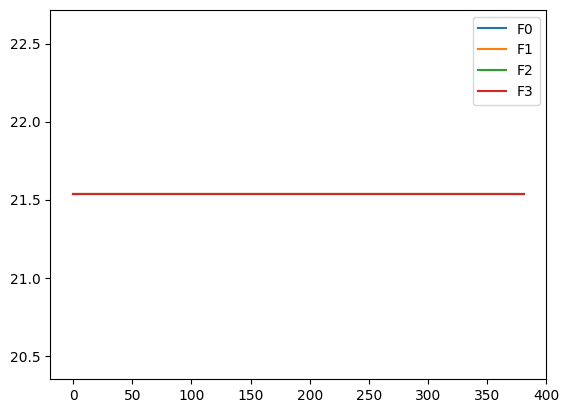

In [57]:
# Original
original_audio = promonet.load.audio('original.wav')
pitch, periodicity = promonet.preprocess.from_audio(
    original_audio,
    gpu=0,
    features=['pitch', 'periodicity'])
pitch, periodicity = pitch.cpu(), periodicity.cpu()
original_formants = promonet.formants.from_audio(
    original_audio,
    promonet.SAMPLE_RATE,
    features='stft',
    decoder='viterbi')
for i, formant in enumerate(original_formants):
    plt.plot(formant, label=f'F{i}')
plt.legend()
ipd.Audio(original_audio, rate=promonet.SAMPLE_RATE)

In [39]:
original_formants[0]

tensor([ 8182.6172,  7149.0234,  7192.0898,  7084.4238,  7428.9551,  7149.0234,
         6782.9590,  6933.6914,  7751.9531,  9883.7402,  9237.7441,  8505.6152,
        10077.5391,  9819.1406,  8850.1465,  9840.6738,  9862.2070,  9108.5449,
         9194.6777,  8397.9492,  7622.7539, 10249.8047,  7428.9551,  7385.8887,
        10981.9336, 10120.6055, 10766.6016,  9862.2070,  9905.2734,  8441.0156,
         9733.0078,  9668.4082,  8354.8828,  9603.8086,  9625.3418,  8118.0176,
         9366.9434,  6546.0938,  6653.7598,  9216.2109,  7364.3555,  6416.8945,
         8936.2793,  9130.0781,  6201.5625,  8764.0137,  8914.7461,  6976.7578,
         8570.2148,  8677.8809,  6847.5586,  7299.7559,  6912.1582,  7235.1562,
         8548.6816,  7945.7520,  6933.6914,  8419.4824,  9539.2090, 11025.0000,
        10077.5391,  9431.5430,  9453.0762,  9087.0117,  8376.4160, 10917.3340,
        11025.0000,  8225.6836,  9496.1426,  8979.3457,  8096.4844,  9689.9414,
         8720.9473,  7945.7520,  9130.07

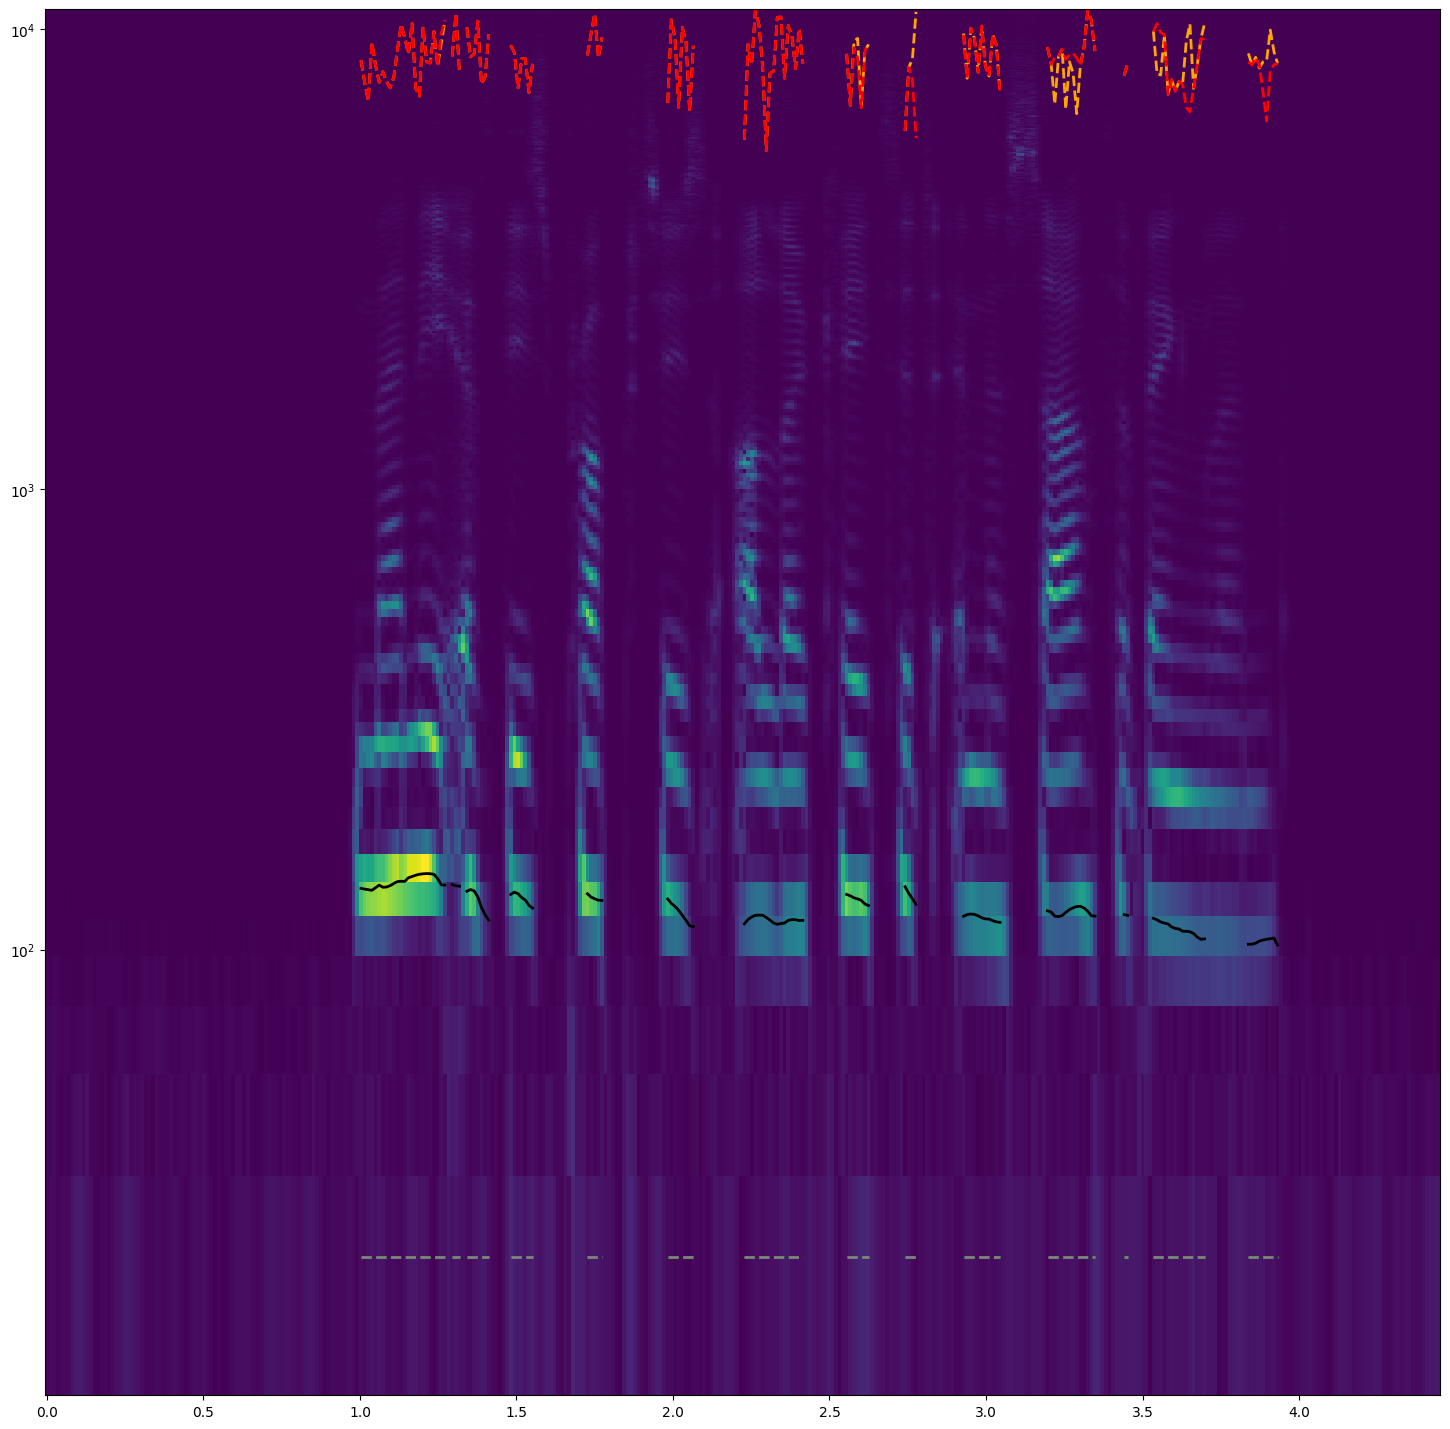

In [32]:
# Plot formants overlayed on Mel spectrogram
plt.figure(figsize=(18, 18))

# Plot Mels
mels = promonet.preprocess.spectrogram.from_audio(original_audio, mels=True)
times = np.linspace(0, promonet.convert.samples_to_seconds(original_audio.shape[-1]), mels.shape[-1])
# center_frequencies = librosa.mel_frequencies(promonet.NUM_MELS + 2)[1:-1]
# plt.pcolormesh(times, center_frequencies, mels)

stft = promonet.preprocess.spectrogram.from_audio(original_audio, mels=False)
stft_frequencies = torch.abs(torch.fft.fftfreq(
    promonet.NUM_FFT,
    1 / promonet.SAMPLE_RATE
)[:promonet.NUM_FFT // 2 + 1])
plt.pcolormesh(times, stft_frequencies[1:], stft[1:])
# features, frequencies = promonet.formants.pitch_posteriorgram(original_audio, promonet.SAMPLE_RATE)
# features = torch.log(features)
# features[features < -80.] = -float('inf')
# features[features > -10.] = -float('inf')
# plt.pcolormesh(times, frequencies, features.T)
plt.yscale('symlog')

# Plot pitch
unvoiced = periodicity[0] < promonet.VOICING_THRESHOLD
x = torch.clone(pitch).squeeze()
x[unvoiced] = float('nan')
plt.plot(times, x, linewidth=2, color='black', label='Pitch')

# These don't seem to work with pcolormesh
# plt.legend()
# plt.show()

# Plot formants
colors = ['orange', 'green', 'red', 'gray']
for i, formant in enumerate(original_formants):
    x = torch.clone(formant)
    x[unvoiced] = float('nan')
    plt.plot(times, x, linewidth=2, color=colors[i], linestyle='--', label=f'F{i}')

In [7]:
x

tensor([     nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan,      nan,      nan,      nan, 152.3926,      nan,
             nan,      nan,      nan,      nan,      nan,      nan,      nan,
             nan,      nan, 135.9300, 135.4032, 134.9639, 134.59

In [ ]:
frequencies.shape

In [ ]:
# Down
down_audio = promonet.load.audio('formant-071.wav')
down_formants = promonet.formants.from_audio(down_audio)
for formant in down_formants:
    plt.plot(formant)
ipd.Audio(down_audio, rate=promonet.SAMPLE_RATE)

In [ ]:
# Up
up_audio = promonet.load.audio('formant-141.wav')
up_formants = promonet.formants.from_audio(up_audio)
for formant in up_formants:
    plt.plot(formant)
ipd.Audio(up_audio, rate=promonet.SAMPLE_RATE)

In [ ]:
# Visualize all formants
colors = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(18, 18))
chunk_size = None
voiced = torch.clone(pitch)
voiced[periodicity < promonet.VOICING_THRESHOLD] = float('nan')
plt.plot(voiced[0, :chunk_size], color='black')
for color, original, down, up in zip(
    colors,
    original_formants,
    down_formants,
    up_formants
):
    original, down, up = original[None], down[None], up[None]
    original[periodicity < 2.0 * promonet.VOICING_THRESHOLD] = float('nan')
    down[periodicity < 2.0 * promonet.VOICING_THRESHOLD] = float('nan')
    up[periodicity < 2.0 * promonet.VOICING_THRESHOLD] = float('nan')
    plt.plot(original[0, :chunk_size], color=color, linestyle='solid', label=f'{torch.min(original[~torch.isnan(original)]):.02f}')
    plt.plot(down[0, :chunk_size], color=color, linestyle='dotted', label=f'{torch.min(down[~torch.isnan(down)]):.02f}')
    plt.plot(up[0, :chunk_size], color=color, linestyle='dashed', label=f'{torch.min(up[~torch.isnan(up)]):.02f}')
plt.legend()

In [ ]:
# TODO - Viterbi decoding for formant estimation